In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import mean_squared_error, f1_score, roc_auc_score, confusion_matrix
from sklearn.decomposition import PCA

from MulticoreTSNE import MulticoreTSNE as TSNE

from __future__ import print_function, division

/home/vdn/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
BIND_THR = 1 - np.log(500) / np.log(50000)

def read_df(filepath):
    df = pd.read_table(filepath, sep="\t")

    df.loc[df.meas > 50000, "meas"] = 50000
    df.meas = 1 - np.log(df.meas) / np.log(50000)
    
    df.mhc = list(map(lambda x: x.replace("-", ""), df.mhc))
    df.mhc = list(map(lambda x: x.replace(":", ""), df.mhc))
    df.mhc = list(map(lambda x: x.replace("*", ""), df.mhc))

    df.loc[df.mhc == "HLAA1", "mhc"] = "HLAA0101"
    df.loc[df.mhc == "HLAA11", "mhc"] = "HLAA0101"
    df.loc[df.mhc == "HLAA2", "mhc"] = "HLAA0201"
    df.loc[df.mhc == "HLAA3", "mhc"] = "HLAA0319"
    df.loc[df.mhc == "HLAA3/11", "mhc"] = "HLAA0319"
    df.loc[df.mhc == "HLAA26", "mhc"] = "HLAA2602"
    df.loc[df.mhc == "HLAA24", "mhc"] = "HLAA2403"

    df.loc[df.mhc == "HLAB44", "mhc"] = "HLAB4402"
    df.loc[df.mhc == "HLAB51", "mhc"] = "HLAB5101"
    df.loc[df.mhc == "HLAB7", "mhc"] = "HLAB0702"
    df.loc[df.mhc == "HLAB27", "mhc"] = "HLAB2720"
    df.loc[df.mhc == "HLAB8", "mhc"] = "HLAB0801"

    df.loc[df.mhc == "HLACw1", "mhc"] = "HLAC0401"
    df.loc[df.mhc == "HLACw4", "mhc"] = "HLAC0401"

    df = df.loc[df.mhc != "HLAB60", :]
    return df

In [13]:
protvec_df = pd.read_table("data/protvec.csv", sep = "\\t", header=None)
protvec = {}
for ind, row in protvec_df.iterrows():
    row = list(row)
    row[0] = row[0][1:]
    row[-1] = row[-1][:-1]
    protvec[row[0]] = np.array(row[1:], dtype=float)
    
    
def pv_vec(seq, protvec=protvec):
    res = np.zeros((100, len(seq) - 2), dtype=float)
    for i in range(len(seq) - 2):
        res[:, i] = protvec[seq[i:i+3]]
    return res


def pv_sum(seq, protvec=protvec):
    res = np.zeros((100,), dtype=float)
    for i in range(len(seq) - 2):
        res += protvec[seq[i:i+3]]
    return res

/home/vdn/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


In [2]:
mhc_df = pd.read_csv("data/mhc_seq_imghtla.csv")
mhc_df.head()

NameError: name 'pd' is not defined

In [4]:
df = read_df("data/bdata.2009.tsv")

human_df = df.loc[df.species == "human", :]
print(human_df.shape)
print(human_df.loc[human_df.peptide_length == 9, :].shape)

# human_peptide = np.zeros((human_df.shape[0], 100), dtype=np.float)
# for i, pep in enumerate(human_df.sequence):
#     human_peptide[i, :] = pv_sum(pep)
    
# human_mhc = np.zeros((human_df.shape[0], 100), dtype=np.float)
# for i, mhc_name in enumerate(human_df.mhc):
#     try:
#         human_mhc[i, :] = pv_sum(mhc_df.sequence[mhc_df.mhc == mhc_name].iloc[0])
#     except Exception:
#         print(human_df.iloc[i])
#         break
        
# tra_X_orig = np.hstack([human_peptide, human_mhc])
# tra_y_orig = human_df.meas

# print(human_df.shape)
# print(tra_X_orig.shape)

(116625, 7)
(90963, 7)


In [5]:
df = read_df("data/blind.tsv")

human_df = df.loc[df.species == "human", :]
print(human_df.shape)
print(human_df.loc[human_df.peptide_length == 9, :].shape)

# human_peptide = np.zeros((human_df.shape[0], 100), dtype=np.float)
# for i, pep in enumerate(human_df.sequence):
#     human_peptide[i, :] = pv_sum(pep)
    
# human_mhc = np.zeros((human_df.shape[0], 100), dtype=np.float)
# for i, mhc_name in enumerate(human_df.mhc):
#     try:
#         human_mhc[i, :] = pv_sum(mhc_df.sequence[mhc_df.mhc == mhc_name].iloc[0])
#     except Exception:
#         print(human_df.iloc[i])
#         break
        
# tst_X_orig = np.hstack([human_peptide, human_mhc])
# tst_y_orig = human_df.meas

# print(human_df.shape)
# print(tst_X_orig.shape)

(25667, 7)
(20425, 7)


In [85]:
from collections import Counter

df = read_df("data/bdata.2009.tsv")
human_df = df.loc[df.species == "human", :]
tra_counts = Counter(human_df.mhc)

df = read_df("data/blind.tsv")
human_df = df.loc[df.species == "human", :]
tst_counts = Counter(human_df.mhc)

print("train\ttest")
for key in set(tra_counts.keys()).union(set(tst_counts.keys())):
    if key not in tst_counts:
        print(key, tra_counts[key], "NA")
    elif key not in tst_counts:
        print(key, "NA", tst_counts[key])
    else:
        print(key, tra_counts[key], tst_counts[key], "->", round(tra_counts[key] / tst_counts[key], 2))

train	test
HLAB4201 3 NA
HLAB4001 2718 407 -> 6.68
HLAE0101 1 NA
HLAB4002 866 74 -> 11.7
HLAB2701 2 NA
HLAB2702 4 NA
HLAA3101 4796 724 -> 6.62
HLAB2705 3028 314 -> 9.64
HLAB1402 3 NA
HLAB4801 861 NA
HLAA3301 3040 473 -> 6.43
HLAB3901 886 641 -> 1.38
HLAB5101 1734 854 -> 2.03
HLAB5301 1018 485 -> 2.1
HLAA1101 5399 723 -> 7.47
HLAA2501 519 416 -> 1.25
HLAA0205 56 NA
HLAA0206 4827 682 -> 7.08
HLAA0207 68 NA
HLAA0201 9609 2126 -> 4.52
HLAA0202 3919 126 -> 31.1
HLAA0203 5542 651 -> 8.51
HLAB3501 2397 542 -> 4.42
HLAB3503 7 NA
HLAB3508 1 NA
HLAB1503 429 165 -> 2.6
HLAB1517 846 582 -> 1.45
HLAB0801 2267 940 -> 2.41
HLAB0803 217 234 -> 0.93
HLAB0802 487 509 -> 0.96
HLAB5701 1857 815 -> 2.28
HLAA2902 2397 118 -> 20.31
HLAA0101 3799 696 -> 5.46
HLAA0219 1203 NA
HLAA0216 894 NA
HLAA0212 1143 NA
HLAA0211 1038 NA
HLAA0210 18 NA
HLAA3002 1430 420 -> 3.4
HLAA3001 2040 660 -> 3.09
HLAA0250 132 NA
HLAB1509 346 466 -> 0.74
HLAA6901 2079 470 -> 4.42
HLAA2602 206 413 -> 0.5
HLAA2603 205 312 -> 0.66
HLAB15

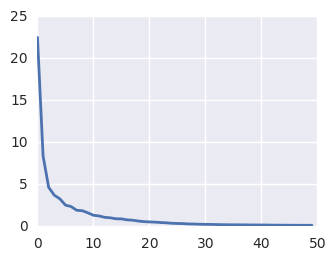

In [165]:
pca = PCA(n_components=50)
pca.fit(tra_X_orig)
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)

In [209]:
pca = PCA(n_components=30)
pca.fit(tra_X_orig)
tra_X = pca.transform(tra_X_orig)
tst_X = pca.transform(tst_X_orig)

In [212]:
clf = xgb.XGBRegressor(n_estimators=3000, max_depth=7, nthread=14, subsample=.8, learning_rate=.003, reg_alpha=.3, reg_lambda=.3, max_delta_step=1.2)
clf = xgb.XGBRegressor(n_estimators=300)
#cross_val_score(X=tra_X, y=tra_y, estimator=clf, cv=3, scoring="mean_squared_error")

In [217]:
clf = xgb.XGBRegressor(n_estimators=1000, max_depth=7, nthread=14, subsample=.8, max_delta_step=1.3)
clf.fit(tra_X, tra_y)
pred = clf.predict(tst_X)

tst_y_clf = np.zeros(pred.shape)
tst_y_clf[np.array(tst_y >= BIND_THR)] = 1

pred_clf = np.zeros(pred.shape)
pred_clf[np.array(pred >= BIND_THR)] = 1

print("F1:", f1_score(tst_y_clf, pred_clf))
print("AUC:", roc_auc_score(tst_y_clf, pred_clf))
print(confusion_matrix(tst_y_clf, pred_clf))

F1: 0.288974750651
AUC: 0.564737233306
[[16146  1028]
 [ 6885  1608]]


In [198]:
clf2 = xgb.XGBRegressor(n_estimators=3000, max_depth=10, nthread=14, subsample=.8, learning_rate=.01)
clf2.fit(tra_X_orig, tra_y)
pred = clf2.predict(tst_X_orig)

tst_y_clf = np.zeros(pred.shape)
tst_y_clf[np.array(tst_y >= BIND_THR)] = 1

pred_clf = np.zeros(pred.shape)
pred_clf[np.array(pred >= BIND_THR)] = 1

print("F1:", f1_score(tst_y_clf, pred_clf))
print("AUC:", roc_auc_score(tst_y_clf, pred_clf))
print(confusion_matrix(tst_y_clf, pred_clf))

F1: 0.0
AUC: 0.5
[[17174     0]
 [ 8493     0]]


In [199]:
clf3 = xgb.XGBRegressor(nthread=14)
clf3.fit(np.vstack([clf.predict(tra_X), clf2.predict(tra_X_orig)]).reshape((tra_X.shape[0], 2)), tra_y)
pred = clf3.predict(np.vstack([clf.predict(tst_X), clf2.predict(tst_X_orig)]).reshape((tst_X.shape[0], 2)))

tst_y_clf = np.zeros(pred.shape)
tst_y_clf[np.array(tst_y >= BIND_THR)] = 1

pred_clf = np.zeros(pred.shape)
pred_clf[np.array(pred >= BIND_THR)] = 1

print("F1:", f1_score(tst_y_clf, pred_clf))
print("AUC:", roc_auc_score(tst_y_clf, pred_clf))
print(confusion_matrix(tst_y_clf, pred_clf))

F1: 0.0
AUC: 0.5
[[17174     0]
 [ 8493     0]]


In [194]:
pred.shape

(116625,)

In [108]:
np.vstack([pred, tst_y]).reshape((25667, 2))

array([[ 0.24373657,  0.30299976],
       [ 0.36034358,  0.1945734 ],
       [ 0.28471643,  0.25750023],
       ..., 
       [ 0.706274  ,  0.240767  ],
       [ 0.565566  ,  0.237354  ],
       [ 0.371403  ,  0.663802  ]])

In [222]:
tst_y_clf = np.zeros(pred.shape)
tst_y_clf[np.array(tst_y >= BIND_THR)] = 1
tst_y_clf.sum()

8493.0

In [176]:
(tst_y >= BIND_THR).sum()

8493

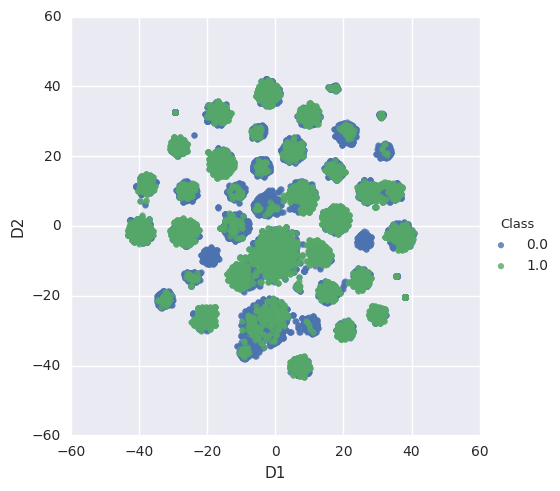

In [238]:
def compute_tsne(perp, data, classes):
    tsne = TSNE(perplexity=perp, n_jobs=8)
    vec_tsne = tsne.fit_transform(data)
    df_tsne = pd.DataFrame({"D1": vec_tsne[:,0], "D2": vec_tsne[:,1], "Class": classes})
    return sns.lmplot("D1", "D2", hue = "Class", data = df_tsne, fit_reg = False)


def compute_tsne2(perp, data, classes, types):
    tsne = TSNE(perplexity=perp, n_jobs=8)
    vec_tsne = tsne.fit_transform(data)
    df_tsne = pd.DataFrame({"D1": vec_tsne[:,0], "D2": vec_tsne[:,1], "Class": classes, "Type": types})
    return sns.lmplot("D1", "D2", hue = "Class", markers = "Type", data = df_tsne, fit_reg = False)


compute_tsne(60, tst_X_orig, tst_y_clf)

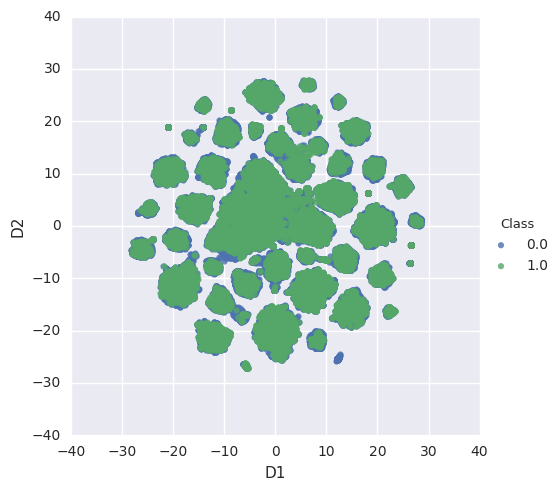

In [221]:
tst_y_clf = np.zeros(tra_y.shape)
tst_y_clf[np.array(tra_y >= BIND_THR)] = 1
compute_tsne(60, tra_X_orig, tst_y_clf)